In [34]:
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from tqdm.notebook import tqdm as tqdm
import jax
import jax.numpy as jnp
from jax.experimental.optimizers import adam
from jax.experimental.stax import *
from jax import random, jit
import numpy as np
import glob
import skimage.io as skio
import skimage as sk
from skimage.transform import resize, rescale
from livelossplot import PlotLosses

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision.transforms import Compose, ColorJitter, Resize, ToTensor

## Data Loading

In [ ]:
%%capture
if not os.path.exists('/content/imm_face_db'):
    !wget http://www2.imm.dtu.dk/~aam/datasets/imm_face_db.zip
    !unzip 'imm_face_db.zip'    
    !rm -r 'imm_face_db.zip'

In [35]:
class ImmFaceDb(Dataset):
    def __init__(self, root_dir, keypoints=[-6], transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
        """
        self.root_dir = root_dir
        img_paths = glob.glob(root_dir + '*.jpg')
        img_paths.sort()
        self.img_paths = np.array(img_paths)
        
        asf_paths = glob.glob(root_dir + '*.asf')
        asf_paths.sort()
        self.asf_paths = np.array(asf_paths)

        self.keypoints = keypoints
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_paths = self.img_paths[idx]
        asf_paths = self.asf_paths[idx]

        imgs = read(img_paths, color=False)
        imgs = imgs - 0.5

        asf_data = self.read_asf(asf_paths, self.keypoints)
        asf_data = np.column_stack((asf_data[0], asf_data[1]))
        sample = {'x': imgs, 'y': asf_data}

        if self.transform:
            sample = self.transform(sample)

        return sample

    def read_asf(self, file, keypoints=None):
        """Reads x, y points from asf file

        Args:
            file (str): path to asf file

        Returns:
            np.ndarray, np.ndarray: list of x points, list of y points
        """
        if keypoints:
            data = np.genfromtxt(file, skip_header=16, skip_footer=1, usecols=(2, 3))[keypoints, :]
        else:
            data = np.genfromtxt(file, skip_header=16, skip_footer=1, usecols=(2, 3))[:, :]
        return data[:, 0], data[:, 1]

In [36]:
from PIL import Image
    
def read(img, color=True):
    # read in the image
    img = skio.imread(img, as_gray=not color)
    
    if not color:
        img = np.expand_dims(img, axis=2)

    # convert to double
    img = sk.img_as_float(img)
    return img

class ColorJitterX(object):
    def __call__(self, sample):
        image, points = sample['x'], sample['y']
        brightness = np.random.random()
        contrast = np.random.random()
        image = image[:, :, 0] * contrast + brightness
        image = image[..., None]
        return {'x': image, 'y': points}

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, points = sample['x'], sample['y']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]
        
        points[:, 0] = points[:, 0] * w
        points[:, 1] = points[:, 1] * h
        points = points - [left, top]
        points[:, 0] = points[:, 0] / new_w
        points[:, 1] = points[:, 1] / new_h
        
        return {'x': image, 'y': points}

class Rescale(object):
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, sample):
        image = sample['x']
        image = rescale(image[:, :, 0], self.scale)[..., None]
        return {'x': image, 'y':sample['y']}

In [37]:
batch_size = 32
validation_split = 0.2
height = 180
width = 240
channels = 1

transforms = Compose([
            Rescale(0.45),
            RandomCrop((height, width)),
            ColorJitterX(),
        ])

dataset = ImmFaceDb('imm_face_db/', keypoints=None, transform=transforms)

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler) 

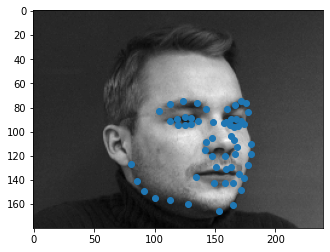

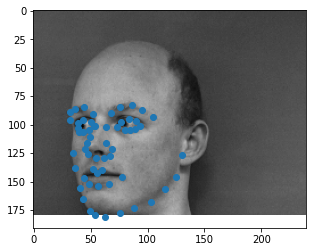

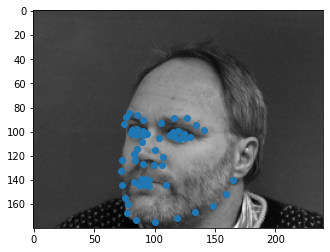

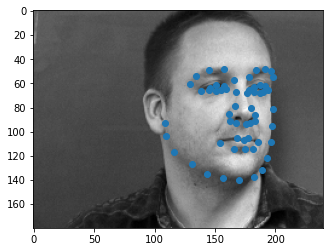

In [59]:
for i, sample in enumerate(train_loader):
    if i > 3:
        break
    
    img = sample['x'][0]
    points = sample['y'][0]
    plt.imshow(img, cmap='gray')
    plt.scatter(points[:, 0] * img.shape[1], points[:, 1] * img.shape[0])
    plt.show()

In [71]:
model_init_fn, model = serial(
    Conv(32, (7, 7)),
    MaxPool((2, 2)),
    Relu,
    Conv(64, (5, 5)),
    MaxPool((2, 2)),
    Relu,
    Conv(128, (3, 3)),
    MaxPool((2, 2)),
    Relu,
    Conv(256, (3, 3)),
    MaxPool((2, 2)),
    Relu,
    Conv(128, (3, 3), padding="SAME"),
    MaxPool((2, 2)),
    Relu,
    Flatten, 
    Dense(512),
    Relu,
    Dense(58*2)
)

In [72]:
# Loss -- MSE
@jit
def loss_fn(params, imgs, gt):
    pred = model(params, imgs)
    pred = pred.reshape(gt.shape)
    return np.mean((pred - gt) ** 2)

@jit
def update(step, opt_state, imgs, gt):
    value, grads = jax.value_and_grad(loss_fn)(opt.params_fn(opt_state), imgs, gt)
    opt_state = opt.update_fn(step, grads, opt_state)
    return value, opt_state

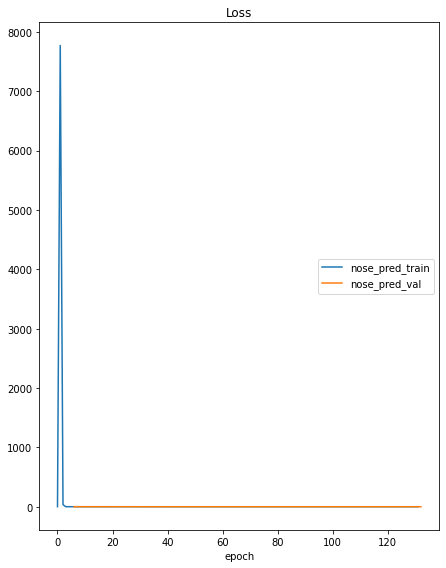

Loss
	nose_pred_train  	 (min:    0.007, max: 7772.943, cur:    0.008)
	nose_pred_val    	 (min:    0.006, max:    0.414, cur:    0.010)


KeyboardInterrupt: 

In [73]:
# Initialize Model
rng = random.PRNGKey(32)
input_shape, params = model_init_fn(rng, (batch_size, height, width, channels))

# Optimizer
lr = 1e-3
opt = adam(lr)
opt_state = opt.init_fn(params)

# Create Plots
plt_groups = {'loss':[]}
plotlosses_model = PlotLosses(groups=plt_groups)
plt_groups['loss'].append('nose_pred_train')
plt_groups['loss'].append('nose_pred_val')

# Training Loop
epochs = 40

iters = 0
val_iters = 0
save_params = params
min_val = 10000

for e in tqdm(range(epochs), leave=False, desc='iter'):
    for batch_i, sample_batch in tqdm(enumerate(train_loader), leave=False, desc='iter'):
        sample_batch['x'] = sample_batch['x'].numpy()
        sample_batch['y'] = sample_batch['y'].numpy()
        
        value, opt_state = update(
            iters,
            opt_state,
            sample_batch['x'],
            sample_batch['y'],
        )

        plotlosses_model.update({'nose_pred_train':value}, current_step=iters)
        iters += 1
    
    # get validation loss
    val_values = []
    for batch_i, sample_valid_batch in tqdm(enumerate(validation_loader), leave=False, desc='iter'):
        sample_valid_batch['x'] = sample_valid_batch['x'].numpy()
        sample_valid_batch['y'] = sample_valid_batch['y'].numpy()
        val_value, grads = jax.value_and_grad(loss_fn)(
            opt.params_fn(opt_state),
            sample_valid_batch['x'],
            sample_valid_batch['y'],
        )
        val_values.append(val_value)
        if val_value <= min_val:
            save_params = opt.params_fn(opt_state)
            min_val = val_value
        
    plotlosses_model.update({'nose_pred_val':np.mean(val_values)}, current_step=iters)
    plotlosses_model.send()


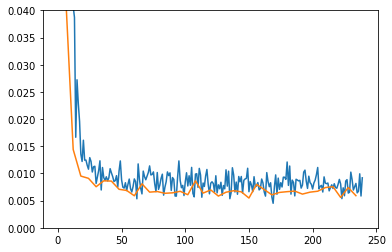

In [69]:
train_loss = [float(x[1]) for x in plotlosses_model.logger.log_history['nose_pred_train']]
val_loss = [float(x[1]) for x in plotlosses_model.logger.log_history['nose_pred_val']]
plt.plot(range(len(train_loss)), train_loss)
plt.plot(range(0, len(train_loss), len(train_loss) // len(val_loss))[:len(val_loss)], val_loss)
plt.ylim(0, .04)
plt.show()

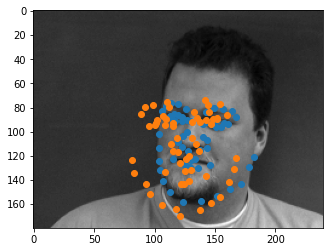

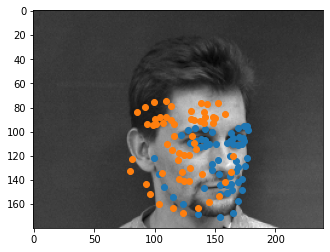

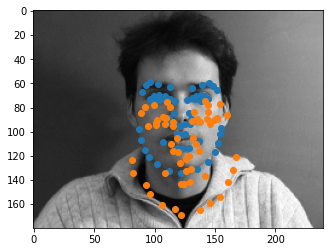

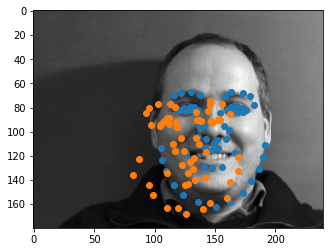

In [70]:
validation_loader = DataLoader(dataset, batch_size=1, sampler=valid_sampler) 
for batch_i, sample_valid_batch in tqdm(enumerate(validation_loader), leave=False, desc='iter'):
    if batch_i > 3:
        break
    val_imgs = sample_valid_batch['x'].numpy()
    val_points = sample_valid_batch['y'].numpy()
    
    pred = model(save_params, val_imgs)
    pred = pred.reshape(val_points.shape)
    
    plt.imshow(val_imgs[0] + 0.5, cmap='gray')
    plt.scatter(val_points[0, :, 0] * width, val_points[0, :, 1] * height)
    plt.scatter(pred[0, :, 0] * width, pred[0, :, 1] * height)
    plt.show()

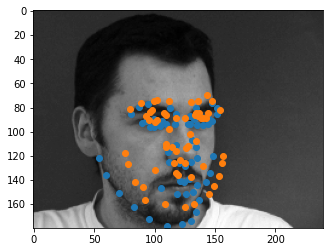

0.008429373


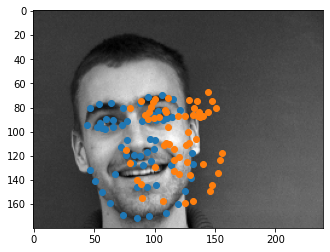

0.0072495155


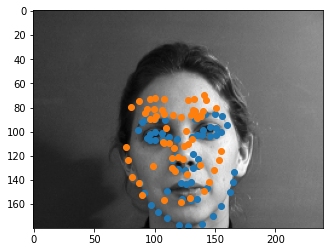

0.0072401534


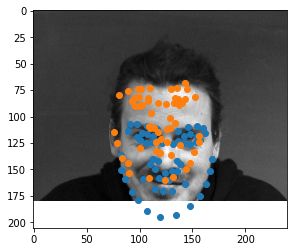

0.009688464


In [58]:
for batch_i, sample_valid_batch in tqdm(enumerate(train_loader), leave=False, desc='iter'):
    if batch_i > 3:
        break
    val_imgs = sample_valid_batch['x'].numpy()
    val_points = sample_valid_batch['y'].numpy()
    pred = model(save_params, val_imgs)
    pred = pred.reshape(val_points.shape)
    plt.imshow(val_imgs[0] + 0.5, cmap='gray')
    plt.scatter(val_points[0, :, 0] * width, val_points[0, :, 1] * height)
    plt.scatter(pred[0, :, 0] * width, pred[0, :, 1] * height)
    plt.show()
    print(np.mean((val_points - pred)**2))

In [16]:
# pickle.dump(save_params, open('checkpoints/part2.p', 'wb'))

In [ ]:
plotlosses_model.send()